In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

import sklearn
from itertools import chain

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

print("Packages Loaded")

Packages Loaded


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      #tf_config = tf.ConfigProto(allow_soft_placement=False)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import wandb
from wandb.keras import WandbCallback
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
wandb.init(project="my-test-project", entity="ibksolar", name=ipynbname.name()+time_stamp,config ={} )
 
config = wandb.config

wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
# Load data
# raw_data1 = loadmat('new_echo_cnn_in_out_jstarrs2021_first_try/echo_cnn_in_out_jstars1.mat')
# raw_data1 = loadmat('echo_cnn_in_out_GOOD_layers/new_echo_cnn_in_out_jstars1.mat') 'findpeaks_layers/new_echo_cnn_in_out_jstars1.mat'

raw_data1 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars1.mat')
raw_data2 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars2.mat')
raw_data3 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars3.mat')
# raw_data4 = loadmat('findpeaks_layers_rowblock20/new_echo_cnn_in_out_jstars4.mat')

d1 = raw_data1['echo_cnn1']
t1 = raw_data1['echo_target1']
i1 = raw_data1['echo_idx1']
c1 = raw_data1['coords1']

d2 = raw_data2['echo_cnn2']
t2 = raw_data2['echo_target2']
i2 = raw_data2['echo_idx2']
c2 = raw_data2['coords2']

d3 = raw_data3['echo_cnn3']
t3 = raw_data3['echo_target3']
i3 = raw_data3['echo_idx3']
c3 = raw_data3['coords3']

# d4 = raw_data4['echo_cnn4']
# t4 = raw_data4['echo_target4']
# i4 = raw_data4['echo_idx4']


orig_all_data = np.concatenate( (d1,d2,d3),axis = 0 )
orig_all_target = np.concatenate( (t1,t2,t3),axis = 0 )
orig_all_idx = np.concatenate( (i1,i2,i3),axis = 0 )
coords = np.concatenate( (c1,c2,c3),axis = 0 )

# Set all nan in the data to zero
nan_idx = np.isnan(orig_all_data).any(axis =-1)
orig_all_target[nan_idx] = 0
orig_all_data[ np.isnan(orig_all_data) ]= 0

In [5]:
# Split based on echograms into small dataset representing training and testing.

config['reduce_test_set'] = True

all_echo_idx = np.unique(orig_all_idx)

# Start split 
test_echo_idx = list(chain.from_iterable( [ list(range(20*n+1,20*n+20)) for n in range(1,max(all_echo_idx)//20,2) ] ) )

# list(set(test_echo_idx) & set(train_echo_idx))

if config['reduce_test_set']:
    #random.Random(13).shuffle(test_echo_idx)
    test_start = 50 ; test_stop = test_start+round(0.3*len(test_echo_idx))
    test_echo_idx = test_echo_idx[test_start:test_stop]
   

# Create train_echo_idx     
train_echo_idx = [int(elem) for elem in all_echo_idx if elem not in test_echo_idx]

# Create new coords idx for each rowblock from all the echograms
val_cnt = [ (orig_all_idx==elem).sum() for elem in train_echo_idx]
new_coords = []
for elem in val_cnt:
    new_coords.append([*range(elem)])
new_coords = np.concatenate(new_coords).ravel()

# Get all idx of echos in train_echo_idx
search_idx = search_idx = np.where(orig_all_idx == train_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
search_idx = list(search_idx[0])

all_data = orig_all_data[search_idx]
all_target = orig_all_target[search_idx]
all_idx = orig_all_idx[search_idx]

np.testing.assert_equal(new_coords.shape[0],all_data.shape[0])

In [6]:
load_new_data = False

if load_new_data:
    # base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
    #base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531'
    base_path = '../all_block_data\FindPeaks_data\Dec_Train_block_len_21_030122_0614'

    # Confirm path is right...
    print(f'{os.path.isdir(base_path)}')

In [7]:
if load_new_data:
    raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
    all_data = raw_data1['echo_cnn_input']
    all_target = raw_data1['echo_cnn_target']
    all_coords = raw_data1['coords']
    echo_idx = raw_data1['orig_echo_idx']

    # Set all nan in the data to zero
    nan_idx = np.isnan(all_data).any(axis =-1)
    all_target[nan_idx] = 0
    all_data[ np.isnan(all_data) ]= 0



In [8]:
# Standardize all_data
standardize = False
if standardize:
    all_data  = ( all_data - all_data.mean() ) / all_data.std()

scale_data = False
if scale_data:
    all_data = 255*all_data

In [9]:
# Truncate data because data after truncate point is not good for training

truncate_data = False
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 400

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')


In [10]:
config['row_length'] = 21 # CHANGE HERE <==
config['col_length'] = 15

# Check that the dimension of data is correct
if all_data.shape[1] == config['row_length']*config['col_length']:
    print('Dimensions match')
else:
    print(f' Row block length:{config["row_length"]} and col length:{config["col_length"]} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [11]:
# Positional Encoding

if 0 :
    time_seq = 9 #col_length #5
    # all_coords = raw_data1['coords']
    all_coord_exp = np.zeros((all_coords.shape[0],time_seq,row_length))

    for idx in range(len(all_coords)):
        a,b,c,_ = np.asarray(all_coords[idx],dtype="int")
        if (a%2) == 0: # If row index is even - this isn't implemented well because it requires iterating through individual rows
            all_coord_exp[idx] = np.sin( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )
        else:
            all_coord_exp[idx] = np.cos( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )

    if 0: #truncate_data:
        difficult_coords = all_coord_exp[stop_idx+1:]         
        all_coord_exp = all_coord_exp[:stop_idx]        


    all_coord_exp.shape    

In [12]:
seq_length = 9

# Create Coords matrix to be used for Positional Embedding
new_coords_mtx = np.zeros( (len(new_coords),seq_length) )

for idx,each_coord in enumerate(new_coords):
    new_coords_mtx[idx] = np.linspace(0, each_coord, num=seq_length)

In [14]:
max_class = config['row_length'] 

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(13).shuffle(all_data)
    random.Random(13).shuffle(all_target)
    # random.Random(13).shuffle(all_coord_exp)
    random.Random(13).shuffle(new_coords_mtx)

## Prep data
train_size = int(np.floor(0.8*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8
neigh =  4

x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1),order ='F' )
x_train = x_train[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_train = np.transpose(x_train,(0,2,1))
coords_train = new_coords_mtx[0:train_size,:]


x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1), order ='F' )
x_test = x_test[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_test = np.reshape(x_test,(x_test.shape[0],-1))
x_test = np.transpose(x_test,(0,2,1))
coords_test = new_coords_mtx[train_size:train_size+test_size,:]


x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1), order ='F' )
x_val = x_val[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_val = np.reshape(x_val,(x_val.shape[0],-1))
x_val = np.transpose(x_val,(0,2,1))
coords_val = new_coords_mtx[-val_size:,:]


y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
config['num_classes'] = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, config['num_classes'])
y_test_1hot  = tf.keras.utils.to_categorical(y_test, config['num_classes'])

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(1349017, 9, 21)  X_test:(252941, 9, 21)
Shape of y_train:(1349017, 1)  y_test:(252941, 1)


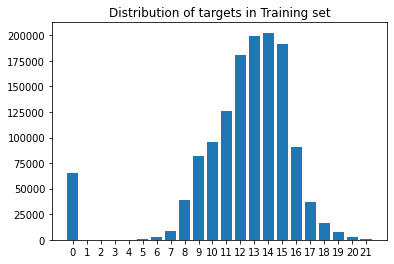

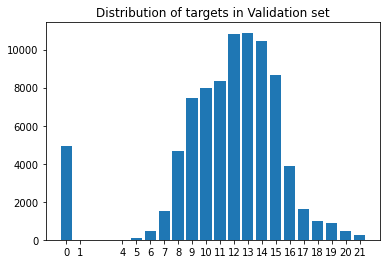

In [15]:
# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()

In [ ]:
if  0:   
    x_train_new = x_train + coords_train
    x_test_new = x_test + coords_test
    x_val_new = x_val + coords_val

In [19]:
# Populate the param 

# import sys,importlib
#importlib.reload(sys.modules['model_hyper_param_log'])
if 1:
    
    base_path =  r'../../../Python_Env/final_layers_rowblock15_21/filtered_image/'
    log ={}
    log['Notebook_name'] = ipynbname.name()
    log['Uniqueness_of_each_run'] = 'New training using LSTM with Position coords 21st March,22: Now 25th-Unseen test data and use first few good samples '
    log['base_dir'] = base_path
    log['Train_shape'] = x_train.shape
    log['Output_shape'] = ''
    log['num_epochs'] = ''
    log['batch_size'] = ''
    log['activation_function'] = ''
    log['optimizer'] = ''
    log['learning_rate'] = ''
    log['loss_finction'] = ''
    log['accuracy'] = []
    log['loss'] = []
    log['stop_time'] = ''
    log['Model_config'] = ''
    log['Performance_on_test_set'] = ''
    log['output_path'] = ''  # output: where the trained model is saved
    log['shuffle'] = shuffle
    log['run_completion_comment'] = '' # Comment on training and probably evaluation too
    log['extras'] = [{'standardize':standardize}]


from model_hyper_param_log import create_log_entry, update_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
loss_function not in workspace
Accuracy_per_epoch not in workspace
Loss_per_epoch not in workspace
Stop_time not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([71, '26_March_22_2037', 'LSTM1_Repeat_NewData-Class_weights', 'New training using LSTM with Position coords 21st March,22: Now 25th-Unseen test data and use first few good samples ', '../../../Python_Env/final_layers_rowblock15_21/filtered_image/', (1349017, 9, 21), '', '', '', '', '', '', '', '', '', '', '', '', 1, 'AQ-98JH673', [{'standardize': False}]])
Fields to be updated include: ['Activa

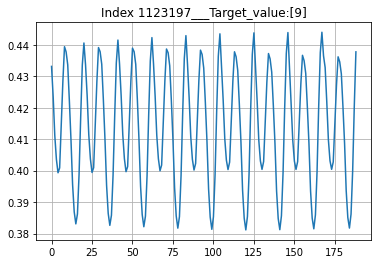

In [17]:
# Visualize some of the input
rand_idx = random.choice( range(1,x_train.shape[0]) )
_ = plt.plot(x_train[rand_idx].flatten())
_ = plt.title(f'Index {rand_idx}___Target_value:{y_train[rand_idx]}' )
_ = plt.grid(which='both')

In [18]:
use_class_weight = True

if use_class_weight:
    each_class,each_count = np.unique(y_train, return_counts = True)
    class_weights = len(y_train) / ( len(each_class) * each_count )
    cl_weight_dict = dict(zip(each_class,class_weights))
    

In [20]:
# Copied from Augment_Reduce: Dealing with overfitting #Custom ResNet + LSTM model
config['Run_notes']='Training again_ removed randomization in Unseen test data and use first few good samples'
config['num_epochs'] = 350
config['batch_size'] = 512
config['learning_rate'] = 5e-3

input_shape = (x_train.shape[1:])# + (1,) #input_shape = (21,5,) #x_train.shape[2]
pos_input_shape = (coords_train.shape[1:])

def ResNetBlock(x,dropout):
    x =   layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.Dropout(dropout)(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.Dropout(dropout)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.add([x,conv3])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x


def build_model(
    input_shape,
    head_size,  
    mlp_units,
    r_dropout,
    mlp_dropout,
):
    inputs = tf.keras.Input(shape=input_shape) 
    pos_inputs = tf.keras.Input(shape= pos_input_shape)
    
    pos_embedding = layers.Embedding(input_dim = np.max(new_coords), output_dim = input_shape[-1])(pos_inputs)
    x = inputs + pos_embedding
    x = layers.LayerNormalization()(x)
#     aug_inputs = data_augmentation(inputs)
    
#     x = layers.Conv2D(filters=32, kernel_size=3, padding="same")(aug_inputs)
#     for _ in range(2):
#         x = ResNetBlock(x,dropout)        
#     x = tf.reduce_sum(x,axis=-1)
    
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x) #input_shape=(x.shape[1:]),
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x)
    #x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x)
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x)
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout)(x)

       
    #for dim in mlp_units:  x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dense(mlp_units, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(config['num_classes'], activation="softmax")(x)
    return tf.keras.Model([inputs,pos_inputs], outputs,name ="RowBlockLSTM"+time_stamp)

# Default hyper-param
config['num_epochs'] = 500
config['batch_size'] = 256
config['learning_rate'] = 3e-4
config['head_size'] = 512 
config['mlp_units']= 512  
config['mlp_dropout']= 0.5
config['dropout']= 0.25          
config['r_dropout'] = 0.3

# Update log['extras']
log['extras'][0].update(wandb.config)
#### ===== End of logging ========

model = build_model(input_shape,head_size = config['head_size'],mlp_units=config['mlp_units'], mlp_dropout= config['mlp_dropout'], r_dropout=config['r_dropout'])


# Poly Rate scheduler
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)


# Callbacks
# Checkpoint path
config['base_path2'] = os.path.abspath(r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest').replace(os.sep,'/')
config['start_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
logz= f"{config['base_path2']}/{ipynbname.name()}/{config['start_time']}_logs/"
callbacks = [
    ModelCheckpoint(f"{config['base_path2']}//{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=20, min_lr=0.00005, verbose=1),
    EarlyStopping(monitor="val_loss", patience=30, verbose=1), 
    TensorBoard(log_dir = logz,histogram_freq = 1,profile_batch = '1,70', embeddings_freq=50),
    WandbCallback()
]

opt1 = tf.keras.optimizers.RMSprop(learning_rate=config['learning_rate'],rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
opt3 = tf.keras.optimizers.SGD(learning_rate=config['learning_rate'], momentum=0.99, nesterov=True, name="SGD")
#poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)

top_K = 3
start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

print(f'Training start time:{start_time}')

model.compile( optimizer=opt2,loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2) , 
              metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")], ) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)


history = model.fit([x_train,coords_train], y_train_1hot,
          epochs= config['num_epochs'],  
          batch_size= config['batch_size'], 
          #validation_split = 0.3,
          validation_data=([x_test,coords_test], y_test_1hot),
          callbacks=callbacks,)
          #class_weight = cl_weight_dict ) 

#model = tf.keras.models.load_model(f"{base_path2}//{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5")

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)

config['end_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M')
print(f'End time {config["end_time"]}')

Training start time:26_March_22_2037
Epoch 1/500
5270/5270 [==============================] - 2114s 400ms/step - loss: 1.8212 - accuracy: 0.5827 - top-3-accuracy: 0.9132 - val_loss: 1.7126 - val_accuracy: 0.6408 - val_top-3-accuracy: 0.9386
Epoch 2/500
5270/5270 [==============================] - 2493s 473ms/step - loss: 1.6171 - accuracy: 0.6970 - top-3-accuracy: 0.9587 - val_loss: 1.5982 - val_accuracy: 0.7097 - val_top-3-accuracy: 0.9584
Epoch 3/500
5270/5270 [==============================] - 2491s 473ms/step - loss: 1.4658 - accuracy: 0.7895 - top-3-accuracy: 0.9782 - val_loss: 1.5226 - val_accuracy: 0.7569 - val_top-3-accuracy: 0.9665
Epoch 4/500
5270/5270 [==============================] - 2493s 473ms/step - loss: 1.3758 - accuracy: 0.8429 - top-3-accuracy: 0.9861 - val_loss: 1.4711 - val_accuracy: 0.7884 - val_top-3-accuracy: 0.9720
Epoch 5/500
5270/5270 [==============================] - 2485s 472ms/step - loss: 1.3196 - accuracy: 0.8753 - top-3-accuracy: 0.9901 - val_loss: 1.

In [ ]:
# Custom ResNet + LSTM model

num_epochs = 200
batch_size = 512
learning_rate = 5e-3

input_shape = (x_train.shape[1:]) + (1,) #input_shape = (21,5,) #x_train.shape[2]

def ResNetBlock(x,dropout):
    x =   layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.Dropout(dropout)(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.Dropout(dropout)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.add([x,conv3])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x


def build_model(
    input_shape,
    head_size,  
    mlp_units,
    dropout,
    mlp_dropout,
):
    inputs = tf.keras.Input(shape=input_shape)  
    
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same")(inputs)
    for _ in range(5):
        x = ResNetBlock(x,dropout)        
    x = tf.reduce_sum(x,axis=-1)
    
    x = layers.LSTM(head_size,recurrent_dropout=0.15, return_sequences=True)(x) #input_shape=(x.shape[1:]),
    x = layers.LSTM(head_size,recurrent_dropout=0.15, return_sequences=True)(x)
    #x = layers.LSTM(head_size,recurrent_dropout=0.1, return_sequences=True)(x)
    x = layers.LSTM(64,recurrent_dropout= 0.3)(x)

       
    #for dim in mlp_units:  x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dense(mlp_units, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs,name ="RowBlockLSTM"+time_stamp)

head_size = 512 # 128, 256,64
mlp_units=512  # 128
mlp_dropout=0.15     #0.4
dropout=0.15          #0.25

model = build_model(input_shape,head_size = head_size,mlp_units=mlp_units, mlp_dropout= mlp_dropout, dropout=dropout)
model.summary()

## Logging tools
wandb.config = {
  "learning_rate": "learning_rate",
  "epochs": num_epochs, 
  "batch_size": batch_size,
  #"nodes": nodes,
  "row_length":row_length,
  "base_path":base_path,
  "head_size":head_size, 
  # "ff_dim":ff_dim, "num_transformer_blocks":num_transformer_blocks,"num_heads":num_heads,
  "mlp_units":mlp_units, "mlp_dropout":mlp_dropout,
  "dropout":dropout
}

# Update Wandb fieds with more params
wandb.config.update(log)

# Update log['extras']
log['extras'][0].update(wandb.config)
#### ===== End of logging ========



# Poly Rate scheduler
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)


# Callbacks
callbacks = [
    ModelCheckpoint(f"{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
    WandbCallback()
]

opt1 = tf.keras.optimizers.RMSprop(learning_rate=1e-3,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
opt3 = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99, nesterov=True, name="SGD")
poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)

top_K = 3
start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

print(f'Training start time:{start_time}')

# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()
#model.compile( optimizer=opt1,loss="sparse_categorical_crossentropy" , metrics=["sparse_categorical_accuracy"],) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)

model.compile( optimizer=opt3,loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2) , 
              metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")], ) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)


history = model.fit(x_train, y_train_1hot,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_split = 0.3,
          # validation_data=(x_test, y_test_1hot),
         callbacks=callbacks,  ) #mcp_save, callbacks=[reduce_lr_loss] class_weight = cl_weight_dict

model = tf.keras.models.load_model(f"{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5")

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)

In [ ]:
# Train further using alll train data and validating with x_test
if  0:    
    history = model.fit(x_train, y_train_1hot,
              epochs= num_epochs, 
              batch_size= batch_size, 
              #validation_split = 0.3,
              validation_data=(x_test, y_test_1hot),
             callbacks=callbacks,  )



In [ ]:
# Re-training using one of the best models: Editing Callbacks to include EarlyStopping

model = tf.keras.models.load_model(r"Y:\\ibikunle\\Python_Project\\Fall_2021\all_block_data\Filteredfiltered_data\LSTM1_RepeatExactly//RowBlockLSTM_ReRunNew_Checkpoint_181222.h5")
# Callbacks
new_callbacks = [
    ModelCheckpoint(r"Y:\\ibikunle\\Python_Project\\Fall_2021\all_block_data\Filteredfiltered_data\LSTM1_RepeatExactly//RowBlockLSTM_ReRunNew_Checkpoint_1812_4.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=10, min_lr=0.00005),
    EarlyStopping(monitor="val_loss", patience=50, verbose=1), 
    WandbCallback()
]
# Reset learning rate
#model.optimizer.learning_rate = 5e-4

history = model.fit(x_train, y_train_1hot,
          epochs= 120, 
          batch_size= batch_size, 
          #validation_split = 0.3,
          validation_data=(x_val, y_val_1hot),
         callbacks=new_callbacks,  ) #mcp_save, callbacks=[reduce_lr_loss] class_weight = cl_weight_dict



In [21]:
log['Uniqueness_of_each_run'] = 'Using Old data from its source'
run_completion_comment = f'Training with coords as 2nd input: Training result look great: train acc 99%, val acc:93%'
if "log_idx" in globals():
    log["S_N"] = log_idx
    log['extras'][0]['run_completion_comment'] = run_completion_comment #'Accuracy_per_epoch'
    log['Accuracy_per_epoch'] = history.history['accuracy'][-1]
    log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
loss_function not in workspace
Loss_per_epoch not in workspace
Stop_time not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([71, '01_April_22_0900', 'LSTM1_Repeat_NewData-Class_weights', 'Using Old data from its source', '../../../Python_Env/final_layers_rowblock15_21/filtered_image/', (1349017, 9, 21), '', '', '', '', '', '', 0.9990519285202026, '', '', '', '', '', 1, 'AQ-98JH673', [{'standardize': False, 'reduce_test_set': True, 'row_length': 21, 'col_length': 15, 'num_classes': 22, 'Run_notes': 'Training again_ removed randomization in Unseen test d

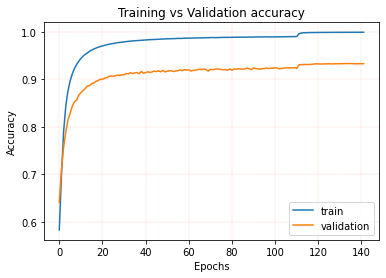

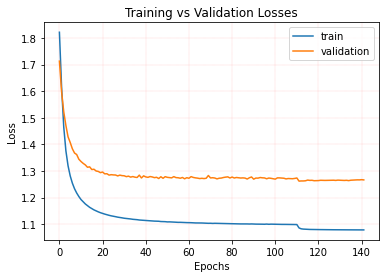

In [22]:
def PlotCurves(model_history):
    plt.plot(model_history.history['accuracy'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    #plt.figure()
    plt.plot(model_history.history['val_accuracy'],label = 'validation')
   
    plt.ylabel('Accuracy');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation accuracy');
    plt.legend()
    
    plt.figure()
    
    plt.plot(model_history.history['loss'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    plt.plot(model_history.history['val_loss'],label = 'validation')
   
    plt.ylabel('Loss');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation Losses');
    plt.legend()
    return None

PlotCurves(history)

In [25]:
#Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, config['num_classes'])

time_stamp = datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')
_, accuracy,top3_acc = model.evaluate([x_val,coords_val], y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'..//all_block_data//PulsedTrainTest//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5') # Last percentage is 46.85, New:52.4

2635/2635 [==============================] - 161s 61ms/step - loss: 1.3304 - accuracy: 0.9127 - top-3-accuracy: 0.9617
Test accuracy: 91.27%
Test top 5 accuracy: 96.17%
Test_time: 01_April_22_0903


In [ ]:
# Convert labels to categorical orthonormal vectors
y_test_1hot = tf.keras.utils.to_categorical(y_test, num_classes)

_, accuracy,top3_acc = model.evaluate(x_test, y_test_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")



In [ ]:
# Train further
train_further = False

if train_further:
    history = model.fit(x_train, y_train_1hot,
          epochs= 200,          
          validation_split= 0.3,
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

In [33]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict([np.expand_dims(x_val[idx],axis=0),np.expand_dims(coords_val[idx],axis=0)] )) ) for idx in range(check_start,check_start+20) ]



Check start 28133


[(11, 11),
 (10, 10),
 (12, 12),
 (17, 17),
 (9, 9),
 (9, 11),
 (11, 11),
 (9, 9),
 (12, 12),
 (13, 13),
 (10, 10),
 (10, 10),
 (14, 14),
 (10, 10),
 (8, 8),
 (12, 12),
 (12, 11),
 (11, 11),
 (8, 8),
 (9, 9)]

In [34]:
# Test model manually on all val data

y_pred = [ np.argmax(model.predict([np.expand_dims(x_val[idx],axis=0),np.expand_dims(coords_val[idx],axis=0)] )) for idx in range(len(x_val)) ]

combined_result = zip(y_val,y_pred)

val_exact_accuracy = 100 * sum([1 if y_pred[idx]==y_val[idx]   else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
val_margin5_accuracy = 100 * sum([1 if abs(y_pred[idx]-y_val[idx]) < 5 else 0 for idx in range(len(y_pred)) ]) / len(y_pred)

print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
print(f' Top 5% accuracy is {val_margin5_accuracy: .5f} %')



 Exact accuracy is  91.26835 %
 Top 5% accuracy is  94.72804 %


In [37]:
# Confusion Matrix and ROC/AUC

model_predictions = np.asarray(y_pred)
ground_truth = y_val.squeeze()

# Prediction per Ground-truth class
class_predictions = [ model_predictions[ground_truth==idx]  for idx in range(config['num_classes']) ]

# Confusion matrix
confusion_mtx = np.zeros((config['num_classes'],config['num_classes']) )

for pred,actual in zip(y_pred,y_val): # Rows=Prediction, Columns = Actual
    confusion_mtx[pred,actual] +=1

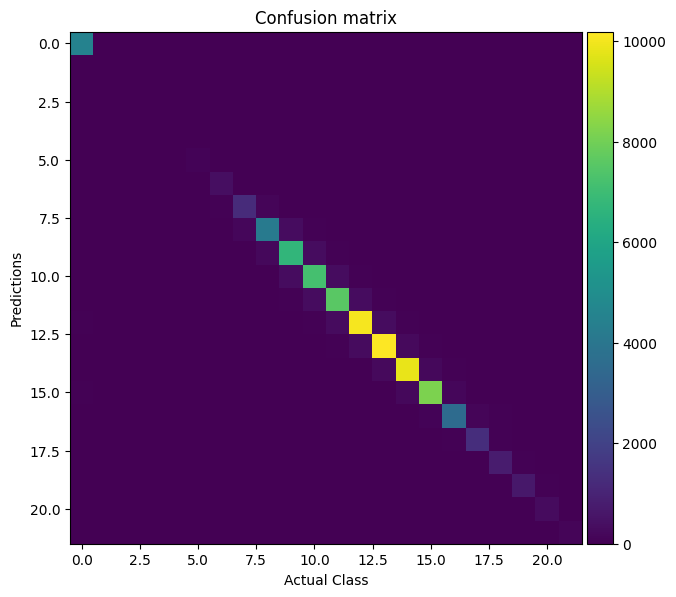

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(7,15),dpi = 100);
shw=ax.imshow(confusion_mtx)
#bar= plt.colorbar(shw)

_=plt.ylabel('Predictions')
_=plt.xlabel('Actual Class')
_=plt.title('Confusion matrix')

# ax.set_xticklabels(list(range(num_classes)))
# ax.set_yticklabels(list(range(num_classes)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#bar.set_label('ColorBar')
_ = plt.colorbar(shw, cax=cax)

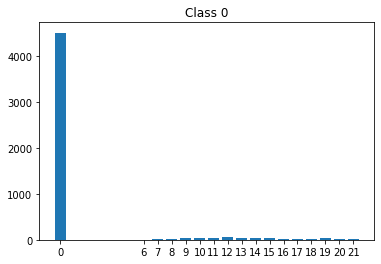

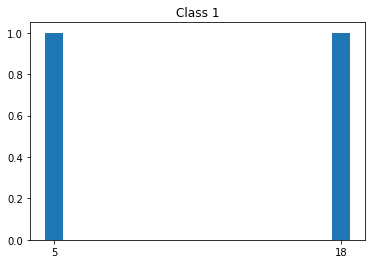

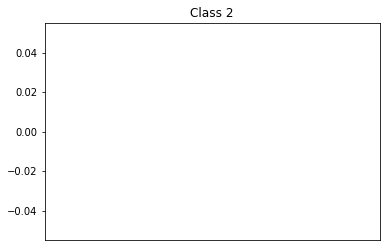

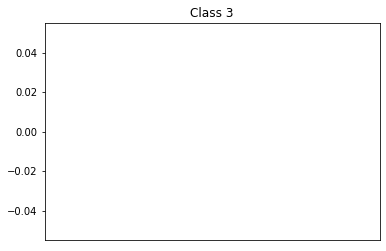

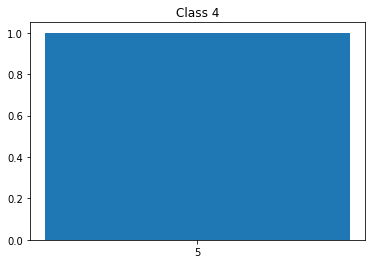

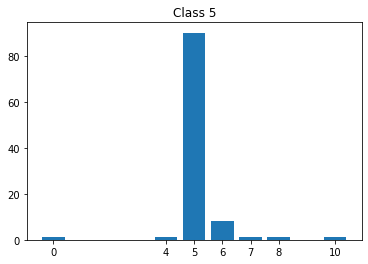

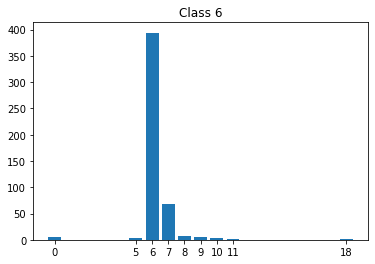

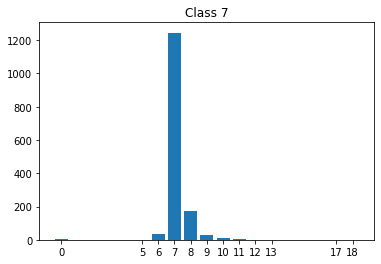

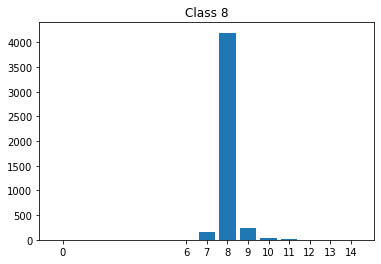

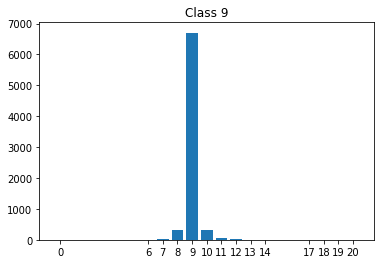

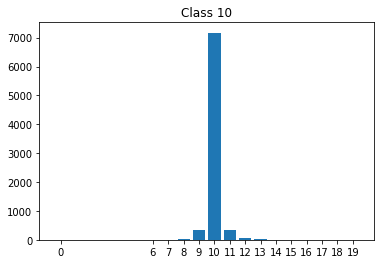

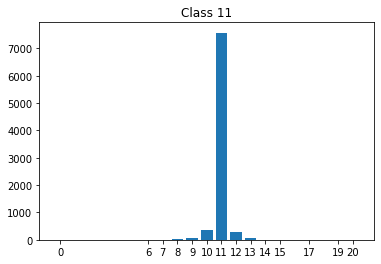

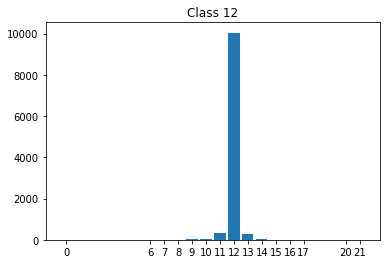

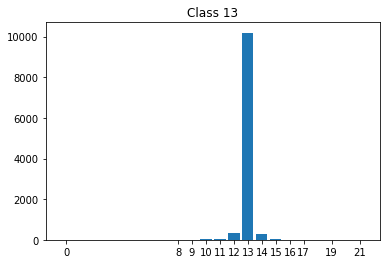

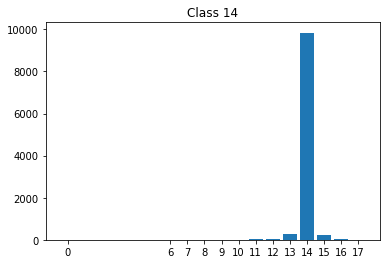

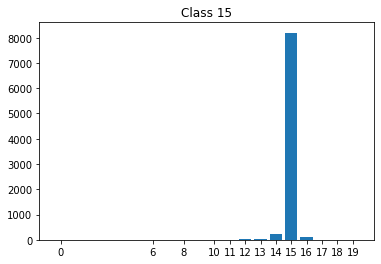

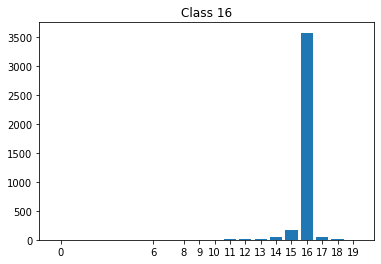

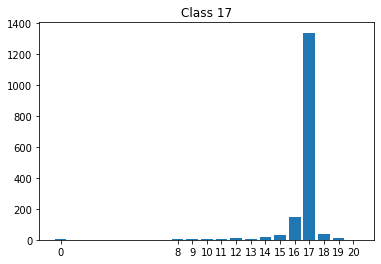

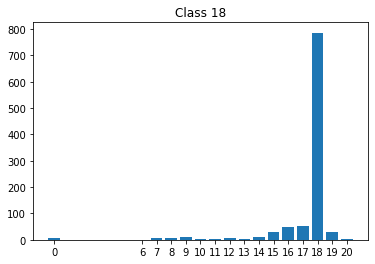

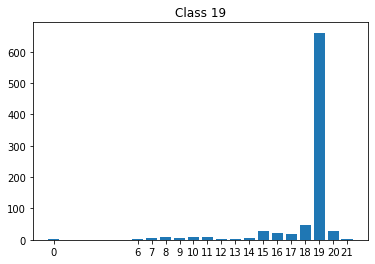

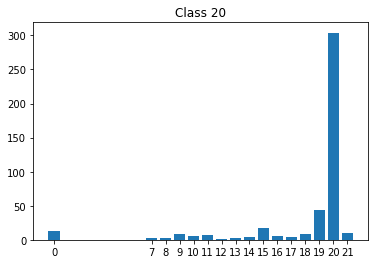

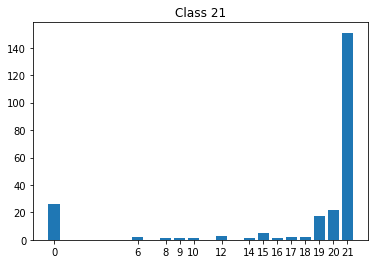

In [39]:
# Histogram of each class prediction
for idx,each_class in enumerate(class_predictions):
    _ = plt.figure()
    _ = plt.title('Class %s'%idx)
    labels, counts = np.unique(each_class, return_counts=True)
    _ = plt.bar(labels, counts, align='center')
    _ = plt.gca().set_xticks(labels)
    _ = plt.show()

In [41]:
from sklearn.metrics import classification_report

print( classification_report( y_val,y_pred, labels=list(range(config['num_classes'])), zero_division=1 ))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4931
           1       1.00      0.00      0.00         2
           2       1.00      1.00      1.00         0
           3       1.00      1.00      1.00         0
           4       0.00      0.00      0.00         1
           5       0.94      0.87      0.90       103
           6       0.84      0.81      0.82       488
           7       0.81      0.83      0.82      1506
           8       0.87      0.90      0.89      4644
           9       0.90      0.90      0.90      7463
          10       0.89      0.90      0.90      7971
          11       0.90      0.91      0.90      8362
          12       0.92      0.93      0.93     10813
          13       0.93      0.94      0.93     10887
          14       0.94      0.94      0.94     10447
          15       0.93      0.95      0.94      8645
          16       0.90      0.92      0.91      3889
          17       0.90    

In [25]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]



Check start 5539


[(10, 9),
 (15, 15),
 (12, 13),
 (12, 12),
 (13, 13),
 (17, 16),
 (11, 9),
 (12, 12),
 (17, 17),
 (14, 14),
 (10, 9),
 (14, 12),
 (18, 18),
 (9, 9),
 (11, 11),
 (16, 16),
 (9, 9),
 (5, 6),
 (0, 0),
 (0, 0)]

In [26]:
# Check model on unseen data from 20120330_04

test_cnt = [ (orig_all_idx==elem).sum() for elem in test_echo_idx]
test_coords = []
for elem in test_cnt:
    test_coords.append([*range(elem)])
test_coords = np.concatenate(test_coords).ravel()

# Get all idx of echos in train_echo_idx
val_search_idx = np.where(orig_all_idx == test_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
val_search_idx = list(val_search_idx[0])

test_data = orig_all_data[val_search_idx]
test_target = orig_all_target[val_search_idx]
test_idx = orig_all_idx[val_search_idx]

In [27]:
seq_length = 9

# Create Coords matrix to be used for Positional Embedding
test_coords_mtx = np.zeros( (len(test_coords),seq_length) )

for idx,each_coord in enumerate(test_coords):
    test_coords_mtx[idx] = np.linspace(0, each_coord, num=seq_length)

In [28]:
# Reshape and prepare unseen test_data

test_data = np.reshape( test_data, (test_data.shape[0],max_class,-1),order ='F' )
test_data = test_data[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
test_data = np.transpose(test_data,(0,2,1))
test_target[test_target == max_class+1 ] = 0

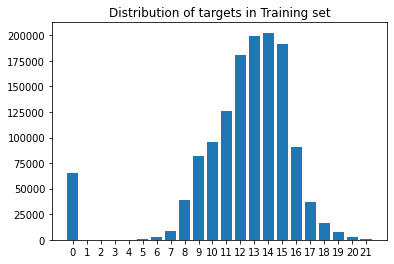

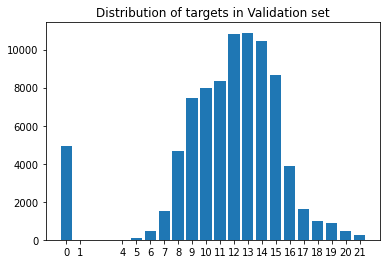

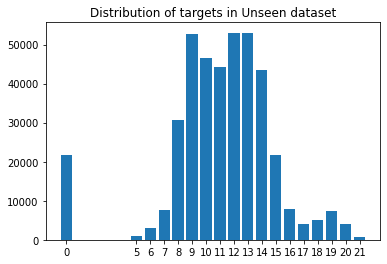

In [29]:
# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()


labels, counts = np.unique(test_target, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Unseen dataset')
_ = plt.show()

In [31]:
# Convert labels to categorical orthonormal vectors
test_target_1hot = tf.keras.utils.to_categorical(test_target, config['num_classes'])

time_stamp = datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')
_, accuracy,top3_acc = model.evaluate([test_data,test_coords_mtx], test_target_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")



12754/12754 [==============================] - 781s 61ms/step - loss: 2.3108 - accuracy: 0.5974 - top-3-accuracy: 0.8172
Test accuracy: 59.74%
Test top 5 accuracy: 81.72%
Test_time: 01_April_22_0921


In [42]:
# Test model manually on all val data

y_pred = [ np.argmax(model.predict([np.expand_dims(test_data[idx],axis=0),np.expand_dims(test_coords_mtx[idx],axis=0)] )) for idx in range(len(test_target)) ]

val_exact_accuracy = 100 * sum([1 if y_pred[idx]==test_target[idx]   else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
val_margin5_accuracy = 100 * sum([1 if abs(y_pred[idx]-test_target[idx]) < 3 else 0 for idx in range(len(y_pred)) ]) / len(y_pred)

print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
print(f' Top 3% accuracy is {val_margin5_accuracy: .5f} %')



 Exact accuracy is  59.74008 %
 Top 3% accuracy is  76.43827 %


In [43]:
# Confusion Matrix and ROC/AUC

model_predictions2 = np.asarray(y_pred)
ground_truth2 = test_target.squeeze()

# Prediction per Ground-truth class
class_predictions2 = [ model_predictions2[ground_truth2==idx]  for idx in range(config['num_classes']) ]

# Confusion matrix
confusion_mtx2 = np.zeros((config['num_classes'],config['num_classes']) )

for pred,actual in zip(y_pred,test_target): # Rows=Prediction, Columns = Actual
    confusion_mtx2[pred,actual] +=1

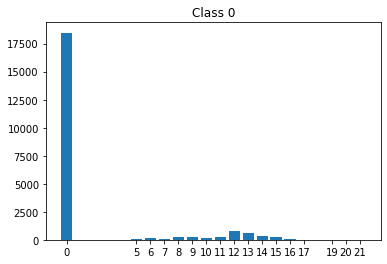

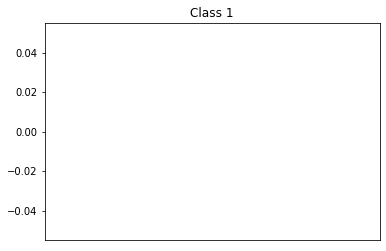

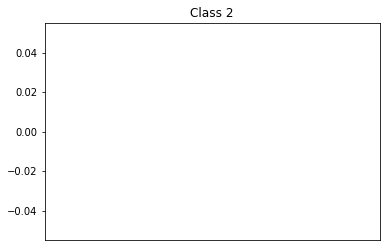

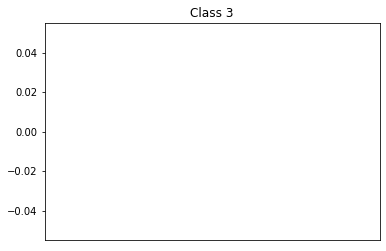

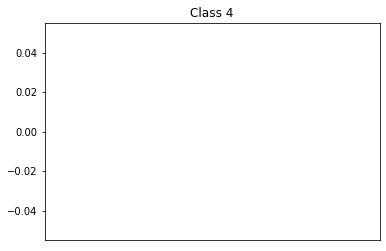

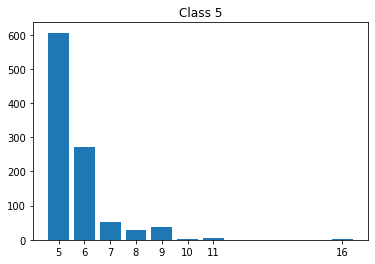

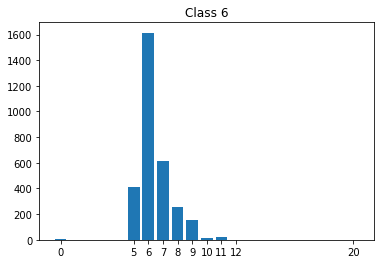

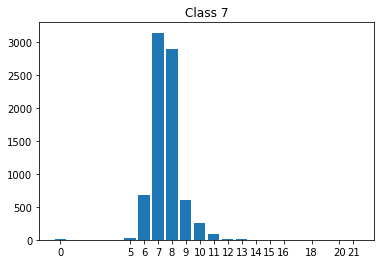

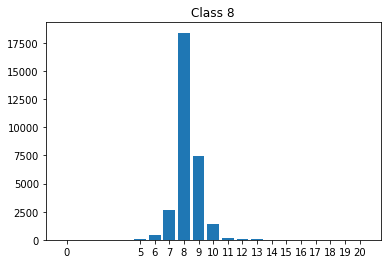

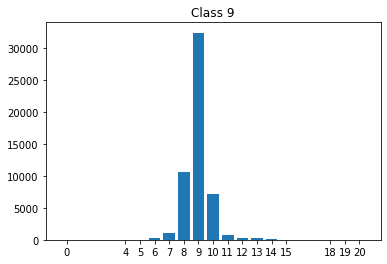

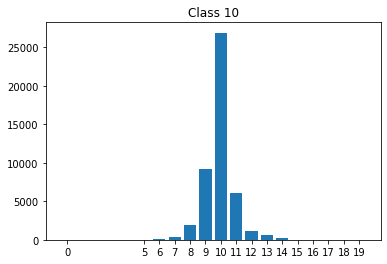

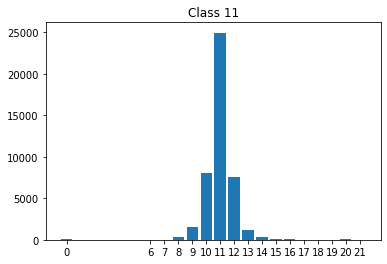

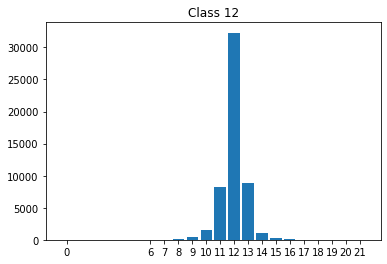

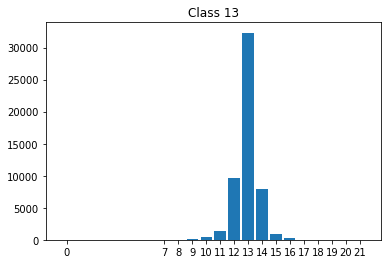

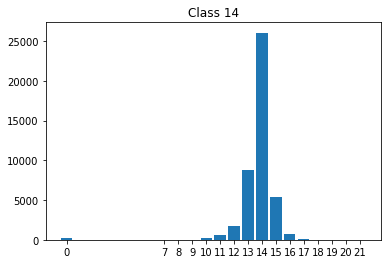

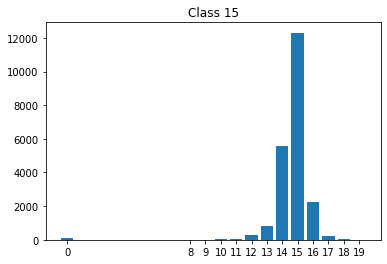

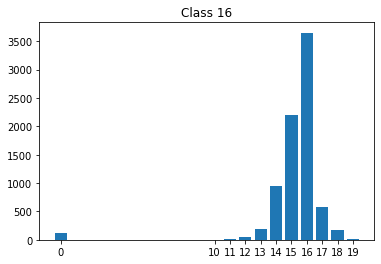

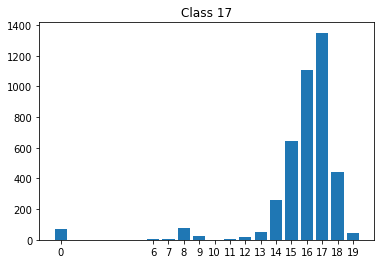

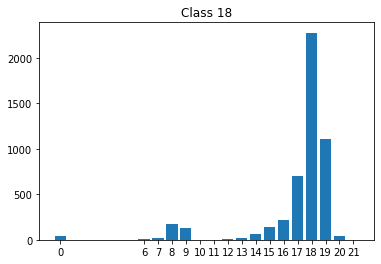

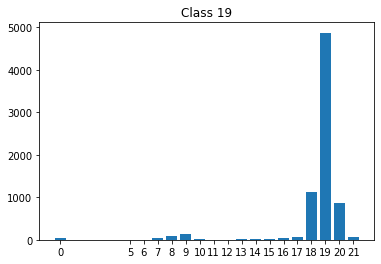

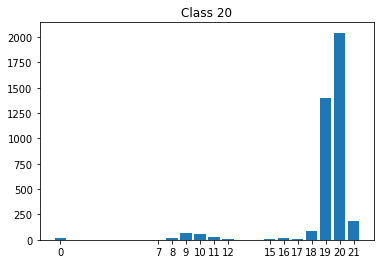

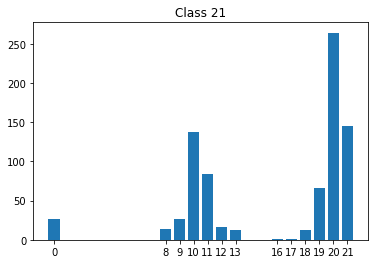

In [44]:
# Histogram of each class prediction
for idx,each_class in enumerate(class_predictions2):
    _ = plt.figure()
    _ = plt.title('Class %s'%idx)
    labels, counts = np.unique(each_class, return_counts=True)
    _ = plt.bar(labels, counts, align='center')
    _ = plt.gca().set_xticks(labels)
    _ = plt.show()

In [45]:
from sklearn.metrics import classification_report

print( classification_report( test_target,y_pred, labels=list(range(config['num_classes'])), zero_division=1 ))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     21646
           1       1.00      1.00      1.00         0
           2       1.00      1.00      1.00         0
           3       1.00      1.00      1.00         0
           4       0.00      1.00      0.00         0
           5       0.53      0.60      0.56      1002
           6       0.47      0.52      0.49      3094
           7       0.39      0.41      0.40      7743
           8       0.53      0.60      0.56     30658
           9       0.62      0.61      0.62     52773
          10       0.58      0.58      0.58     46528
          11       0.59      0.56      0.57     44341
          12       0.60      0.61      0.61     52907
          13       0.60      0.61      0.61     53025
          14       0.61      0.60      0.60     43568
          15       0.55      0.57      0.56     21706
          16       0.44      0.46      0.45      7953
          17       0.44    

In [54]:
# Try prediction on difficult data

x_difficult = raw_data1['echo_cnn_input'][stop_idx+1:]
y_difficult = raw_data1['echo_cnn_target'][stop_idx+1:]

x_difficult = np.reshape( x_difficult, (x_difficult.shape[0],max_class,-1) )
x_difficult = x_difficult[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_difficult = np.transpose(x_difficult,(0,2,1))

# y_difficult[y_difficult == num_classes] = 0
# y_difficult = tf.keras.utils.to_categorical(y_difficult, num_classes)


In [55]:
(x_difficult.shape,y_difficult.shape)

((1724672, 9, 21), (1724672,))

In [61]:
# Check some predictions

difficult_start = random.randint(0,len(x_val)) #3500 #

print(f'Check start {difficult_start}')
[(int(y_difficult[idx]), np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) ) for idx in range(difficult_start,difficult_start+50) ]



Check start 32030


[(14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (14, 12),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9),
 (19, 9)]

In [ ]:
# Attempt loading past model (after crash) and start training again
load_model = 0
if load_model:
    model2 = tf.keras.models.load_model(r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\Old_data\Dec_Train_block_len_21_131121_2213\NewAttention_RowBlockLSTM1\22_November_21_0929_Acc_0.669_Top3Acc0.8506_21x9.h5'
                                    ,)

In [ ]:
# Train further
batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 30, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
# Train further still( 30th Nov.,2021 X_train is returned back to default [i.e No shuffle] )
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 2, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
# Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)

_, accuracy,top3_acc = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5')

In [ ]:
# Test model on val data

y_diff_pred = [ np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) for idx in range(3000,3050) ] #len(x_difficult)

difficult_exact_accuracy = 100 * sum([1 if y_diff_pred[idx]==y_difficult[idx]   else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)
difficult_margin5_accuracy = 100 * sum([1 if abs(y_diff_pred[idx]-y_difficult[idx]) < 3 else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)

print(f' Exact accuracy is {difficult_exact_accuracy: .5f} %')
print(f' Top 5% accuracy is {difficult_margin5_accuracy: .5f} %')



In [ ]:
len(y_diff_pred)